In [3]:
# Dependencies and Setup
from census import Census
from config import (census_key, gkey)
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from us import states
import matplotlib.pyplot as plt

# Census API Key
c = Census(census_key, year=2017)
gmaps.configure(api_key=gkey)

In [5]:
# Run Census Search to retrieve data on all states
# Note the addition of "B23025_005E" for unemployment count
census_data = c.acs5.get(("NAME","B01003_001E", "B19013_001E","B19301_001E","B17001_002E","B23025_005E",), {
                         'for': 'county:*'})



In [6]:
# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"NAME": "County Name","B01003_001E": "Population",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B23025_005E": "Unemployment Count",
                                      "county": "County","state":"State"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Add in Employment Rate (Employment Count / Population)
census_pd["Unemployment Rate"] = 100 * \
    census_pd["Unemployment Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame

census_pd['FIPS Code'] = census_pd['State'].astype(str) + census_pd['County'].astype(str)
census_pd = census_pd[["FIPS Code","County", "State","County Name","Population","Household Income","Per Capita Income","Poverty Count","Poverty Rate","Unemployment Count", "Unemployment Rate"]]
census_pd.head()

,FIPS Code,County,State,County Name,Population,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Count,Unemployment Rate
0,72047,047,72,"Corozal Municipio, Puerto Rico",34933.0,14752.0,7887.0,19146.0,54.807775,3296.0,9.435205
1,72095,095,72,"Maunabo Municipio, Puerto Rico",11297.0,17636.0,8830.0,5945.0,52.624591,735.0,6.506152
2,72111,111,72,"Peñuelas Municipio, Puerto Rico",21661.0,16868.0,7983.0,12379.0,57.148793,1601.0,7.391164
3,72113,113,72,"Ponce Municipio, Puerto Rico",148863.0,16561.0,10775.0,75187.0,50.507514,7013.0,4.711043
4,72131,131,72,"San Sebastián Municipio, Puerto Rico",38970.0,14275.0,8072.0,21472.0,55.098794,3307.0,8.486015


In [7]:
len(census_pd)

3220

In [8]:
# File to Load
CDC_Data = "CDC_Data.csv"

# Read CDC File and store into Pandas data frame and format/reorder/rename
CDC_Table = pd.read_csv("CDC_Data.csv", encoding="ISO-8859-1",converters={'STCOUNTYFP': '{:0>5}'.format})
CDC_Table['STCOUNTYFP'] = CDC_Table.astype({"STCOUNTYFP": str})
CDC_Table = CDC_Table.rename(columns={"STCOUNTYFP": "FIPS Code"})


#Replace all values that say "missing" with 0 and convert to int
CDC_Table['Deaths'] = CDC_Table['Deaths'].replace({'Missing': '0'})
CDC_Table['Deaths'] = CDC_Table['Deaths'].astype(int)


In [9]:
#Merge census dataframe and CDC dataframe using FIPS code as the index, drop any N/A values
new_merged_df = pd.merge(census_pd,CDC_Table,how='outer',on='FIPS Code')
new_merged_df = new_merged_df.dropna(how='any')

#Calculate Deaths per 100K people and add column to dataframe
new_merged_df['Per 100K'] = 100000 * \
     new_merged_df['Deaths'].astype(int) / new_merged_df['Population_y'].astype(int)

new_merged_df.head()

,FIPS Code,County_x,State,County Name,Population_x,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Count,Unemployment Rate,County_y,Deaths,Population_y,Crude Rate,% of Total Deaths,Per 100K
84,01073,073,01,"Jefferson County, Alabama",659460.0,49321.0,29456.0,113368.0,17.191035,25044.0,3.797653,"Jefferson County, AL",167.0,659197,25.3,0.40%,25.333853
97,01117,117,01,"Shelby County, Alabama",208721.0,74063.0,35330.0,17127.0,8.205691,4650.0,2.227854,"Shelby County, AL",27.0,213605,12.6,0.10%,12.640154
98,01115,115,01,"St. Clair County, Alabama",86937.0,53483.0,24686.0,11656.0,13.407410,2354.0,2.707708,"St. Clair County, AL",15.0,88199,Unreliable,0.00%,17.006996
100,01003,003,01,"Baldwin County, Alabama",203360.0,52562.0,29364.0,23728.0,11.667978,5215.0,2.564418,"Baldwin County, AL",19.0,212628,Unreliable,0.00%,8.935794
101,01043,043,01,"Cullman County, Alabama",81703.0,40997.0,21857.0,13157.0,16.103448,1962.0,2.401381,"Cullman County, AL",12.0,82755,Unreliable,0.00%,14.500634


In [16]:
# Store 'Lat' and 'Lng' into  locations 
counties = new_merged_df['County Name'].astype(list)


lat = []
lng = []
counter = 0
print(f'Beginning Data Retrieval')
print(f'-----------------------------')
# Extract latitude and longitude by feeding county name into google maps API
for county in counties:
    target_url = (f'https://maps.googleapis.com/maps/api/geocode/json?address={county}&key={gkey}')
    geo_data = requests.get(target_url).json()
    #append latitude and longitude for every county to lists above
    lat.append(geo_data["results"][0]["geometry"]["location"]["lat"])
    lng.append(geo_data["results"][0]["geometry"]["location"]["lng"])
    counter += 1
    print(f'Processing record {counter} | {county}')
print(f'-----------------------------')
print(f'Data Retrieval Complete')
print(f'-----------------------------')

#Zip two lists together to form new dataframe for county coordinates
list_of_counties = list(zip(lat, lng))
counties_df = pd.DataFrame(list_of_counties)


#Convert datatype of coordinates to float

coordinates = counties_df.astype(float)

#Save results down to CSV as the google API takes several minutes to extract data
coordinates.to_csv("coordinates.csv", encoding="utf-8", index=False)

Beginning Data Retrieval
-----------------------------
Processing record 1 | Jefferson County, Alabama
Processing record 2 | Shelby County, Alabama
Processing record 3 | St. Clair County, Alabama
Processing record 4 | Baldwin County, Alabama
Processing record 5 | Cullman County, Alabama
Processing record 6 | Tuscaloosa County, Alabama
Processing record 7 | Etowah County, Alabama
Processing record 8 | DeKalb County, Alabama
Processing record 9 | Mobile County, Alabama
Processing record 10 | Madison County, Alabama
Processing record 11 | Matanuska-Susitna Borough, Alaska
Processing record 12 | Juneau City and Borough, Alaska
Processing record 13 | Anchorage Municipality, Alaska
Processing record 14 | Pima County, Arizona
Processing record 15 | Maricopa County, Arizona
Processing record 16 | Cochise County, Arizona
Processing record 17 | Yavapai County, Arizona
Processing record 18 | Pinal County, Arizona
Processing record 19 | Pulaski County, Arkansas
Processing record 20 | Saline County

Processing record 169 | Howard County, Indiana
Processing record 170 | Randolph County, Indiana
Processing record 171 | Madison County, Indiana
Processing record 172 | Floyd County, Indiana
Processing record 173 | Allen County, Indiana
Processing record 174 | Delaware County, Indiana
Processing record 175 | Morgan County, Indiana
Processing record 176 | St. Joseph County, Indiana
Processing record 177 | Kosciusko County, Indiana
Processing record 178 | Vanderburgh County, Indiana
Processing record 179 | LaPorte County, Indiana
Processing record 180 | Wabash County, Indiana
Processing record 181 | Jay County, Indiana
Processing record 182 | Porter County, Indiana
Processing record 183 | Tippecanoe County, Indiana
Processing record 184 | Hamilton County, Indiana
Processing record 185 | Bartholomew County, Indiana
Processing record 186 | Lake County, Indiana
Processing record 187 | Montgomery County, Indiana
Processing record 188 | Clark County, Indiana
Processing record 189 | Fayette Cou

Processing record 334 | Sussex County, New Jersey
Processing record 335 | Cumberland County, New Jersey
Processing record 336 | Somerset County, New Jersey
Processing record 337 | Essex County, New Jersey
Processing record 338 | Ocean County, New Jersey
Processing record 339 | Atlantic County, New Jersey
Processing record 340 | Gloucester County, New Jersey
Processing record 341 | Middlesex County, New Jersey
Processing record 342 | Passaic County, New Jersey
Processing record 343 | Cape May County, New Jersey
Processing record 344 | Camden County, New Jersey
Processing record 345 | Bergen County, New Jersey
Processing record 346 | Union County, New Jersey
Processing record 347 | Warren County, New Jersey
Processing record 348 | Hudson County, New Jersey
Processing record 349 | Hunterdon County, New Jersey
Processing record 350 | Burlington County, New Jersey
Processing record 351 | Morris County, New Jersey
Processing record 352 | San Juan County, New Mexico
Processing record 353 | Ch

Processing record 499 | Montgomery County, Ohio
Processing record 500 | Trumbull County, Ohio
Processing record 501 | Warren County, Ohio
Processing record 502 | Wood County, Ohio
Processing record 503 | Ashtabula County, Ohio
Processing record 504 | Wagoner County, Oklahoma
Processing record 505 | Cleveland County, Oklahoma
Processing record 506 | Tulsa County, Oklahoma
Processing record 507 | Oklahoma County, Oklahoma
Processing record 508 | Marion County, Oregon
Processing record 509 | Clackamas County, Oregon
Processing record 510 | Josephine County, Oregon
Processing record 511 | Lane County, Oregon
Processing record 512 | Washington County, Oregon
Processing record 513 | Multnomah County, Oregon
Processing record 514 | Newport County, Rhode Island
Processing record 515 | Kent County, Rhode Island
Processing record 516 | Providence County, Rhode Island
Processing record 517 | Washington County, Rhode Island
Processing record 518 | Delaware County, Pennsylvania
Processing record 51

Processing record 661 | Roanoke County, Virginia
Processing record 662 | Fauquier County, Virginia
Processing record 663 | Harrison County, West Virginia
Processing record 664 | Ohio County, West Virginia
Processing record 665 | Morgan County, West Virginia
Processing record 666 | Lincoln County, West Virginia
Processing record 667 | Raleigh County, West Virginia
Processing record 668 | Putnam County, West Virginia
Processing record 669 | Boone County, West Virginia
Processing record 670 | McDowell County, West Virginia
Processing record 671 | Wayne County, West Virginia
Processing record 672 | Mercer County, West Virginia
Processing record 673 | Berkeley County, West Virginia
Processing record 674 | Fayette County, West Virginia
Processing record 675 | Hampshire County, West Virginia
Processing record 676 | Mingo County, West Virginia
Processing record 677 | Hancock County, West Virginia
Processing record 678 | Wood County, West Virginia
Processing record 679 | Mason County, West Virg

,0,1
0,33.491412,-86.982429
1,33.303929,-86.661108
2,33.653011,-86.337676
3,30.601074,-87.776333
4,34.201154,-86.822034


In [11]:
#reimport csv as new variable so we don't have to run the data extract every single time
coordinates_csv = pd.read_csv("coordinates.csv", dtype="float", encoding="utf-8")

In [12]:
#Convert the Opioid Deaths per 100K column of merged df to a float list
deaths_100K = new_merged_df["Per 100K"].astype(float)

In [13]:
#Google heatmaps using lat/long coordinates above weighted by deaths per 100K people, dynamic scaling (default intensity)
fig = gmaps.figure()
colors = ("maroon","red","yellow","green","blue","teal")
heat_layer = gmaps.heatmap_layer(coordinates_csv, weights=deaths_100K, 
                                 dissipating=False,
                                 point_radius = 0.5,opacity=0.5)


In [14]:
 # Convert number of deaths per county to a list
deaths_list = new_merged_df["Deaths"].tolist()

In [20]:
# Create death symbol layer and infobox which contains deaths in that county. Still haven't figured out how to 
#loop county name into the info box
deaths_layer = gmaps.symbol_layer(
    coordinates_csv, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=1,
    info_box_content=[f"2017 Opioid Related Deaths: \n{row}" for row in deaths_list])

# ---------------------------------------------------

# ['FIPS Code',
#  'County_x',
#  'State',
#  'County Name',
#  'Population_x',
#  'Household Income',
#  'Per Capita Income',
#  'Poverty Count',
#  'Poverty Rate',
#  'Unemployment Count',
#  'Unemployment Rate',
#  'County_y',
#  'Deaths',
#  'Population_y',
#  'Crude Rate',
#  '% of Total Deaths',
#  'Per 100K']

In [21]:
# Create a combined map
fig = gmaps.figure()

fig.add_layer(heat_layer)
fig.add_layer(deaths_layer)

fig

Figure(layout=FigureLayout(height='420px'))

C:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


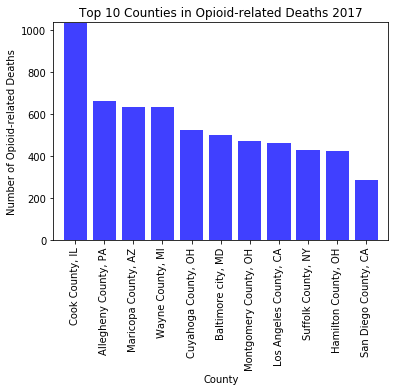

In [23]:
#Create bar graph for top 10 cities with greatest amount of Opioid-related Deaths plus San Diego
#sort CDC dataframe based on number of deaths and create dataframe
sorted_deaths_df = CDC_Table.sort_values("Deaths", ascending=False)
top_10_df_deaths = sorted_deaths_df.head(10)


sd_df = CDC_Table[CDC_Table['County'] == 'San Diego County, CA']
sd_df['Deaths'] = sd_df['Deaths'].astype(int)
#Join San Diego with top 10
top_10_df_deaths = top_10_df_deaths.append(sd_df)



x_axis = np.arange(0, len(top_10_df_deaths))
tick_locations = []
for x in x_axis:
    tick_locations.append(x)

plt.title("Top 10 Counties in Opioid-related Deaths 2017")
plt.xlabel("County")
plt.ylabel("Number of Opioid-related Deaths")

plt.xlim(-0.75, len(top_10_df_deaths)-.25)
plt.ylim(0, max(top_10_df_deaths['Deaths']) + 5)

plt.bar(x_axis, top_10_df_deaths['Deaths'], facecolor="blue", alpha=0.75, align="center")
plt.xticks(tick_locations, top_10_df_deaths['County'],rotation=90)
plt.savefig("BarDeaths.png")
plt.show()


C:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


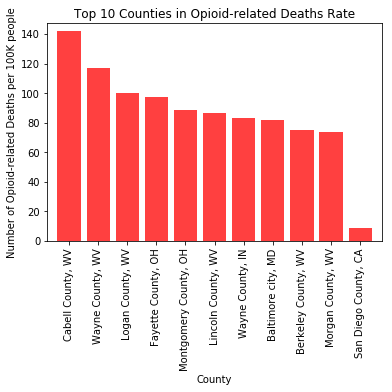

In [63]:
#Create bar graph for top 10 cities with greatest amount of Opioid-related Deaths per 100K plus San Diego
#sort CDC dataframe based on number of deaths per 100K and create dataframe
new_merged_df['Per 100K'] = new_merged_df['Per 100K'].astype(float)
sorted_deathrate_df = new_merged_df.sort_values("Per 100K", ascending=False)
top_10_df_rate = sorted_deathrate_df.head(10)



sd_rate_df = new_merged_df[new_merged_df['County_y'] == 'San Diego County, CA']
sd_rate_df['Per 100K'] = sd_rate_df['Per 100K'].astype(float)
#Join San Diego with top 10
top_10_df_rate = pd.concat([top_10_df_rate, sd_rate_df])


x_axis = np.arange(0, len(top_10_df_rate))
tick_locations = []
for x in x_axis:
    tick_locations.append(x)

plt.title("Top 10 Counties in Opioid-related Deaths Rate")
plt.xlabel("County")
plt.ylabel("Number of Opioid-related Deaths per 100K people")

plt.xlim(-0.75, len(top_10_df_deaths)-.25)
plt.ylim(0, max(top_10_df_rate['Per 100K']) + 5)

plt.bar(x_axis, top_10_df_rate['Per 100K'], facecolor="red", alpha=0.75, align="center")
plt.xticks(tick_locations, top_10_df_rate['County_y'],rotation=90)
plt.savefig("BarDeathRate.png")
plt.show()


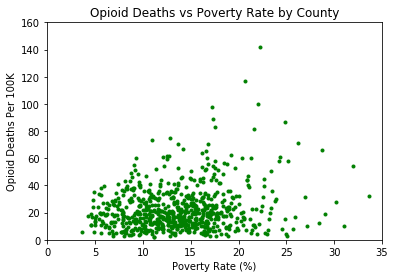

In [60]:
#Scatterplot to see relationship between poverty rate and opioid deaths per 100K people. 
#Do the counties where the epidemic is particularly bad have an abnormally high poverty rate?
poverty_rate = new_merged_df['Poverty Rate'].tolist()
death_scatter = new_merged_df['Per 100K'].tolist()

plt.scatter(poverty_rate, death_scatter, marker=".", color="green")
plt.title("Opioid Deaths vs Poverty Rate by County")
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Opioid Deaths Per 100K")
plt.xlim(0,35)
plt.ylim(0,160)
plt.savefig("ScatterPoverty.png")
plt.show()

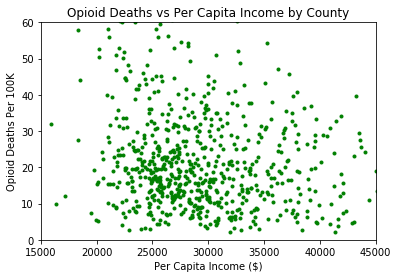

In [61]:
#Scatterplot to see relationship between unemployment rate and opioid deaths per 100K people. 
#Do the counties where the epidemic is particularly bad suffer from low income and are poor?

percapita_rate = new_merged_df['Per Capita Income'].tolist()
income_scatter = new_merged_df['Per 100K'].tolist()

plt.scatter(percapita_rate, income_scatter, marker=".", color="green")
plt.title("Opioid Deaths vs Per Capita Income by County")
plt.xlabel("Per Capita Income ($)")
plt.ylabel("Opioid Deaths Per 100K")
plt.xlim(15000,45000)
plt.ylim(0,60)
plt.savefig("ScatterPerCapita.png")
plt.show()

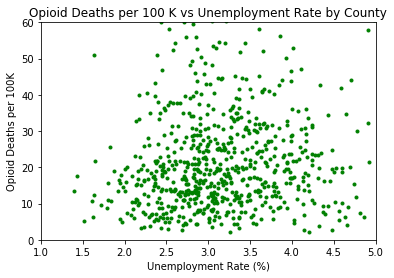

In [62]:
#Scatterplot to see relationship between unemployment rate and opioid deaths per 100K people. 
#Do the counties where the epidemic is particularly bad suffer from high unemployment?
unemployment_rate = new_merged_df['Unemployment Rate'].tolist()
income_scatter = new_merged_df['Per 100K'].tolist()

plt.scatter(unemployment_rate, income_scatter, marker=".", color="green")
plt.title("Opioid Deaths per 100 K vs Unemployment Rate by County")
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Opioid Deaths per 100K")
plt.xlim(1,5)
plt.ylim(0,60)
plt.savefig("ScatterUnemployment.png")
plt.show()